In [129]:
%reload_ext autoreload
%autoreload 2

In [101]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from pprint import pprint
from omegaconf import OmegaConf

In [67]:
import sys
import os

src_path = os.path.abspath("../src")
if src_path not in sys.path:
    sys.path.insert(0, src_path)

In [110]:
from data import load_mnist_dataloaders, unpatchify
from model import VisionToSequence
from config import load_config
from inference import decode_sequence_greedy, InferenceWrapper

In [61]:
cache_dir = os.path.expanduser("~/experiment_data/datasets")

In [80]:
def tensor_to_str(x):
    if x.dim() == 0:
        return str(x.item())
    else:
        return ','.join(str(i.item()) for i in x)

def show_image(image, label, patch_size=14):
    print("Image shape: ", image.shape)

    plt.imshow(unpatchify(image).squeeze(), cmap='gray')
    plt.title(f'Label: {tensor_to_str(label)}')
    plt.axis('off')
    plt.show()

def show_first_image_from_loader(data_loader, patch_size=14):
    # Get the first batch from data_loader
    images, labels = next(iter(data_loader))
    show_image(images[0], labels[0])

Image shape:  torch.Size([4, 196])


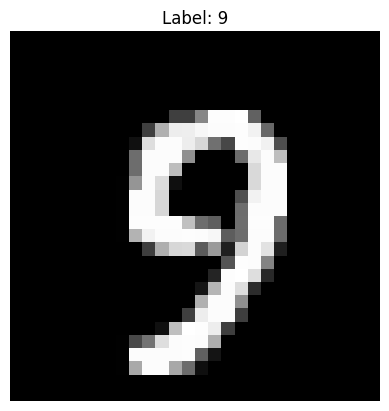

In [130]:
train_loader_image_classification, _, _ = load_mnist_dataloaders(cache_dir)
show_first_image_from_loader(train_loader_image_classification)

In [131]:
images, labels = next(iter(train_loader_image_classification))

In [132]:
images[0]

tensor([[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -

Generating composite dataset: /Users/anton/experiment_data/datasets/MNIST/d5833fd2a1071c5cfd7909735a89a1b6.pkl


Generating composite MNIST: 100%|██████████| 10000/10000 [00:02<00:00, 3337.18it/s]


Generating composite dataset: /Users/anton/experiment_data/datasets/MNIST/d42c047e612e9d8ad30138e6816454c5.pkl


Generating composite MNIST: 100%|██████████| 2000/2000 [00:00<00:00, 3689.24it/s]


Image shape:  torch.Size([16, 196])


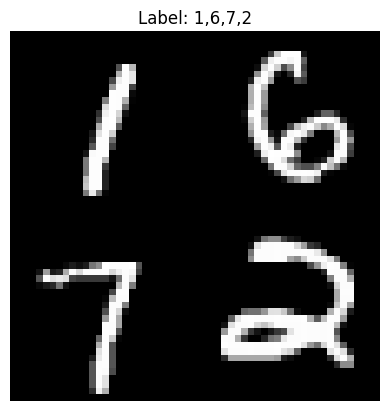

In [63]:
train_loader_composite_fixed, _, _ = load_mnist_dataloaders(
    cache_dir,
    composite_mode=True,
    canvas_size=(56, 56),
    num_digits=4,
    placement='grid'  # or 'random'
)
show_first_image_from_loader(train_loader_composite_fixed)

Generating composite dataset: /Users/anton/experiment_data/datasets/MNIST/725c29bdc0522b33c1cce2f3d57d0adc.pkl


Generating composite MNIST: 100%|██████████| 10000/10000 [00:03<00:00, 2694.86it/s]


Generating composite dataset: /Users/anton/experiment_data/datasets/MNIST/b757f040f5c004dfca8e8b11094894ae.pkl


Generating composite MNIST: 100%|██████████| 2000/2000 [00:00<00:00, 2835.98it/s]


Image shape:  torch.Size([36, 196])


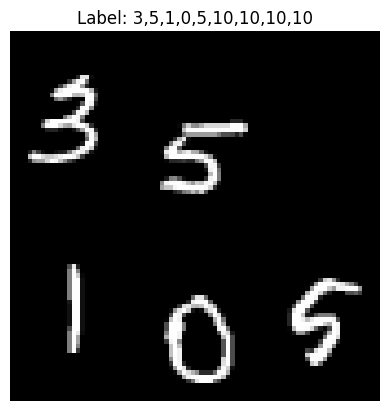

In [64]:
train_loader_composite_random, _, _ = load_mnist_dataloaders(
    cache_dir,
    composite_mode=True,
    canvas_size=(84, 84),
    num_digits_range=(5, 9),
    placement='random'
)
show_first_image_from_loader(train_loader_composite_random)

In [105]:
cfg = load_config(r"/Users/anton/mlx/src/week3/config/default_seq2seq.yaml")
pprint(OmegaConf.to_container(cfg, resolve=True))

{'dataset': {'batch_size': 8,
             'cache_dir': '/Users/anton/experiment_data/datasets',
             'canvas_size_h': 56,
             'canvas_size_w': 56,
             'num_digits': 4,
             'num_digits_range': [10, 20],
             'num_images': 50000,
             'num_images_test': 10000,
             'num_patches': 16,
             'patch_size': 14,
             'placement': 'grid',
             'valid_fraction': 0.2},
 'log': {'project': 'vision_to_sequence', 'run_name': 'test', 'wandb': True},
 'model': {'add_pos_emb': True,
           'dot_product_norm': True,
           'dropout': 0.0,
           'embed_dim': 64,
           'mlp_dim': 128,
           'num_heads': 4,
           'num_layers_decoder': 6,
           'num_layers_encoder': 6,
           'num_patches': 16,
           'save_path_base': '/Users/anton/mlx/src/week3/models/vision_to_sequence'},
 'train': {'epochs': 5, 'lr': 0.001, 'seed': 42}}


In [76]:
model = VisionToSequence(
    cfg.dataset.patch_size * cfg.dataset.patch_size,
    max_len=10,  # FIXME auto-detect this number
    embed_dim=cfg.model.embed_dim,
    num_heads=cfg.model.num_heads,
    mlp_dim=cfg.model.mlp_dim,
    num_layers_encoder=cfg.model.num_layers_encoder,
    num_layers_decoder=cfg.model.num_layers_decoder,
    num_patches=cfg.dataset.num_patches)


In [77]:
model.load_state_dict(torch.load(r"/Users/anton/mlx/src/week3/models/vision_to_sequence_20250625_191520_fabbw3wa.pt", map_location='cpu'))

<All keys matched successfully>

In [78]:
train_loader, val_loader, test_loader = load_mnist_dataloaders(
    cfg.dataset.cache_dir,
    cfg.dataset.batch_size,
    cfg.dataset.valid_fraction,
    cfg.dataset.patch_size,
    cfg.train.seed,
    composite_mode=True,
    canvas_size=(cfg.dataset.canvas_size_w, cfg.dataset.canvas_size_h),
    num_digits=cfg.dataset.num_digits,
    placement=cfg.dataset.placement,
    num_digits_range=None, # TODO Support this cfg.dataset.num_digits_range,
    num_images=cfg.dataset.num_images,
    num_images_test=cfg.dataset.num_images_test)


Loading cached dataset: /Users/anton/experiment_data/datasets/MNIST/d5833fd2a1071c5cfd7909735a89a1b6.pkl
Loading cached dataset: /Users/anton/experiment_data/datasets/MNIST/d42c047e612e9d8ad30138e6816454c5.pkl


In [82]:
images, labels = next(iter(val_loader))

Image shape:  torch.Size([16, 196])


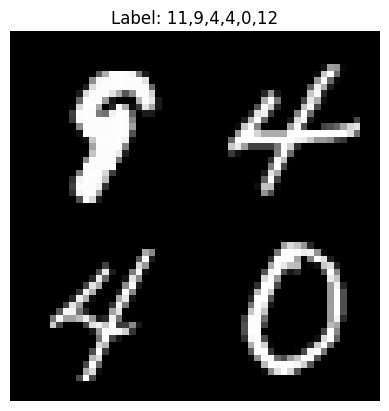

In [83]:
show_image(images[0], labels[0])

In [92]:
images[0].unsqueeze(dim=0)

tensor([[[-0.4242, -0.4242, -0.4242,  ...,  2.7960,  2.7833,  2.7833],
         [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
         ...,
         [-0.4242,  1.6505,  2.4524,  ..., -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]])

In [95]:
decoded_sequence = decode_sequence_greedy(model, images[0].unsqueeze(dim=0))

In [96]:
decoded_sequence

[[9, 4, 4, 0]]

In [125]:
cfg = load_config(r"/Users/anton/mlx/src/week3/config/default_seq2seq_random.yaml")
pprint(OmegaConf.to_container(cfg, resolve=True))

{'dataset': {'batch_size': 8,
             'cache_dir': '/Users/anton/experiment_data/datasets',
             'canvas_size_h': 84,
             'canvas_size_w': 84,
             'grid_cols': 3,
             'grid_rows': 3,
             'num_digits': None,
             'num_digits_range': [0, 9],
             'num_images': 100000,
             'num_images_test': 20000,
             'num_patches': 36,
             'patch_size': 14,
             'placement': 'random',
             'valid_fraction': 0.2},
 'log': {'project': 'vision_to_sequence', 'run_name': 'test', 'wandb': True},
 'model': {'add_pos_emb': True,
           'dot_product_norm': True,
           'dropout': 0.0,
           'embed_dim': 256,
           'mlp_dim': 128,
           'num_heads': 8,
           'num_layers_decoder': 6,
           'num_layers_encoder': 6,
           'num_patches': 36,
           'save_path_base': '/Users/anton/mlx/src/week3/models/vision_to_sequence_random'},
 'train': {'epochs': 10, 'lr': 0.0001, 's

In [134]:
model = VisionToSequence(
    cfg.dataset.patch_size * cfg.dataset.patch_size,
    max_len=10,  # FIXME auto-detect this number
    embed_dim=cfg.model.embed_dim,
    num_heads=cfg.model.num_heads,
    mlp_dim=cfg.model.mlp_dim,
    num_layers_encoder=cfg.model.num_layers_encoder,
    num_layers_decoder=cfg.model.num_layers_decoder,
    num_patches=cfg.dataset.num_patches)

In [135]:
model.load_state_dict(torch.load(r"/Users/anton/mlx/src/week3/models/vision_to_sequence_random_20250627_125335_ewred489.pt", map_location='cpu'))

<All keys matched successfully>

In [136]:
import onnx

In [120]:
%pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 6.7 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [137]:
dummy_input = torch.randn(1, 36, 196)
wrapped = InferenceWrapper(model)
wrapped.eval()
torch.onnx.export(wrapped, dummy_input, "model.onnx",
                  input_names=['input'], output_names=['output'],
                  dynamic_axes={'input': {0: 'batch'}, 'output': {0: 'batch'}})